In [18]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages


def progresss(pred_path, old=False):
    if old:
        best_f1 = "eval_best_f1"
        noans_f1 = "eval_NoAns_f1"
        ans_f1 = "eval_HasAns_f1"
    else:
        best_f1 = "best_f1"
        noans_f1 = "NoAns_f1"
        ans_f1 = "HasAns_f1"
    folder_path = pred_path             # Replace with the actual folder path
    checkpoints = {}
    for seed_name in os.listdir(folder_path):
        seed_folder = os.path.join(folder_path, seed_name)
        for checkpoint_name in os.listdir(seed_folder):


            cp = int(checkpoint_name.split("-")[-1])
            if cp not in checkpoints:
                checkpoints[cp] = {'SQuAD2': [], '|AGent-SQuAD2|': []}
            squad2_path = os.path.join(seed_folder, checkpoint_name, "SQuAD/squad2/dev-v2.0-new-format")
            for file_name in os.listdir(squad2_path):
                if file_name == "eval_results.json":
                    file_path = os.path.join(squad2_path, file_name)
                    with open(file_path, "r") as file:
                        data = json.load(file)
                        squad2_f1 = data.get(best_f1)
                        squad2_noans_f1 = data.get(ans_f1)
                        if squad2_f1 is not None:
                            checkpoints[cp]['SQuAD2'].append(squad2_f1)
            
            agent_path = os.path.join(seed_folder, checkpoint_name, "AGent/SQuAD_AGent_dev")
            for file_name in os.listdir(agent_path):
                if file_name == "eval_results.json":
                    file_path = os.path.join(agent_path, file_name)
                    with open(file_path, "r") as file:
                        data = json.load(file)
                        agent_f1 = data.get(noans_f1)
                        if agent_f1 is not None:
                            checkpoints[cp]['|AGent-SQuAD2|'].append(abs(agent_f1-squad2_noans_f1))
    
        # Sort checkpoints dictionary in ascending order based on keys
    sorted_checkpoints = dict(sorted(checkpoints.items()))
    # Extract HasAns_f1 and NoAns_f1 values
    return sorted_checkpoints

def plot_progress(sorted_checkpoints, old=False):
    x_SQuAD = list(sorted_checkpoints.keys())
    y_SQuAD = [sum(values['SQuAD2']) / len(values['SQuAD2']) for values in sorted_checkpoints.values()]
    error_SQuAD = [np.std(values['SQuAD2']) for values in sorted_checkpoints.values()]

    x_AGent = list(sorted_checkpoints.keys())
    y_AGent = [sum(values['|AGent-SQuAD2|']) / len(values['|AGent-SQuAD2|']) for values in sorted_checkpoints.values()]
    error_AGent = [np.std(values['|AGent-SQuAD2|']) for values in sorted_checkpoints.values()]
    f = plt.figure(figsize=(4, 3))
    plt.style.use("_mpl-gallery")
    plt.ylim(top=80, bottom=-1)  # adjust the top leaving bottom unchanged
    plt.xticks(rotation=45)
    plt.errorbar(x_SQuAD, y_SQuAD, yerr=error_SQuAD, ecolor='firebrick', capsize=4, label='Performance on SQuAD2', color='firebrick', linestyle='--', marker='d')
    plt.errorbar(x_AGent, y_AGent, yerr=error_AGent, ecolor='navy', capsize=4, label='Performance Gap', color='navy', marker='o')
    # plt.errorbar(x_SQuAD, y_SQuAD, yerr=error_SQuAD, ecolor='blue', capsize=4, label='Performance on SQuAD2')
    # plt.errorbar(x_AGent, y_AGent, yerr=error_AGent, ecolor='orange', capsize=4, label='Performance Gap on unanswerable questions')
    plt.xlabel('Checkpoints')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()
    f.savefig("figures/{}.pdf".format('Devlin') if old else "figures/{}.pdf".format('Ours'), bbox_inches='tight')

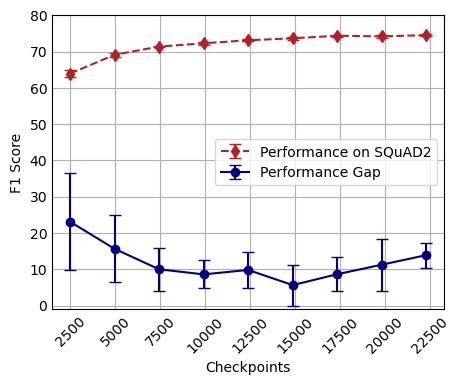

In [19]:
pred_path = "/Volumes/Share/tran_s2/SQuAD2_new/Progress/SQuADv2-multians/bert-base-cased"
new_checkpoints = progresss(pred_path, old=False)
plot_progress(new_checkpoints)

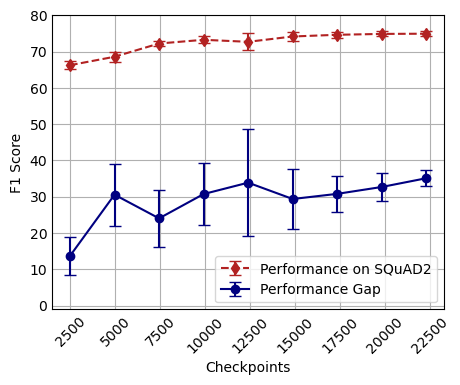

In [20]:
pred_path = "/Volumes/Share/tran_s2/SQuAD2_new/Progress/SQuADv2-old/bert-base-cased"
old_checkpoints = progresss(pred_path, old=True)
plot_progress(old_checkpoints, old=True)